# Store Sales Time Series Clustering (Kaggle)

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [ ]:
# Load the datasets
# Adjust file paths as needed for your environment
train = pd.read_csv('../data/samples/train.csv')
stores = pd.read_csv('../data/samples/stores.csv')
transactions = pd.read_csv('../data/samples/transactions.csv')
oil = pd.read_csv('../data/samples/oil.csv')
holidays = pd.read_csv('../data/samples/holidays_events.csv')

# Display basic info
print("Train data shape:", train.shape)
train.head()

Train data shape: (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
# Basic statistics of sales data
train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [6]:
# Check for missing values
print("Missing values in train data:")
print(train.isnull().sum())

Missing values in train data:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [7]:
# Explore store information
print("Store information:")
stores.head()

Store information:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


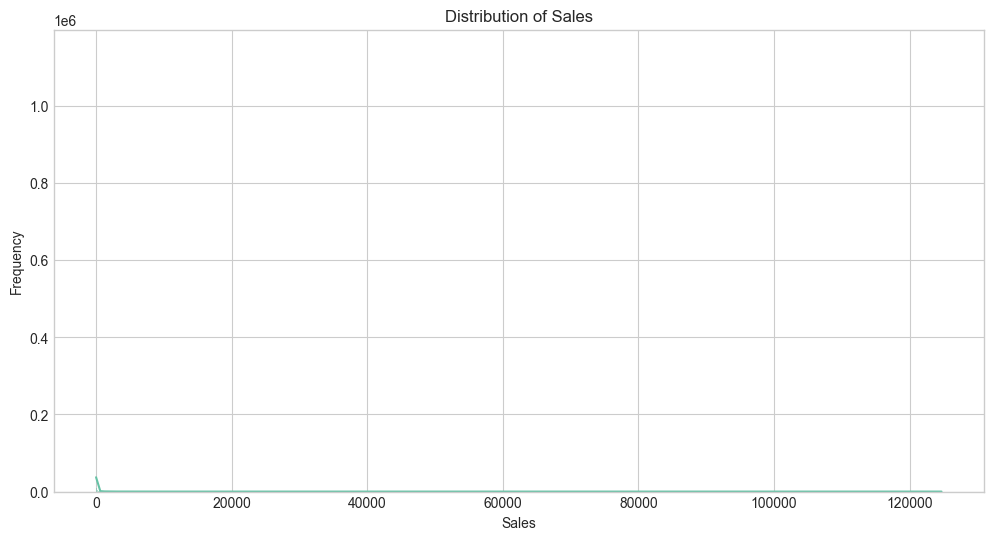

In [8]:
# Plot distribution of sales
plt.figure(figsize=(12, 6))
sns.histplot(train['sales'], kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

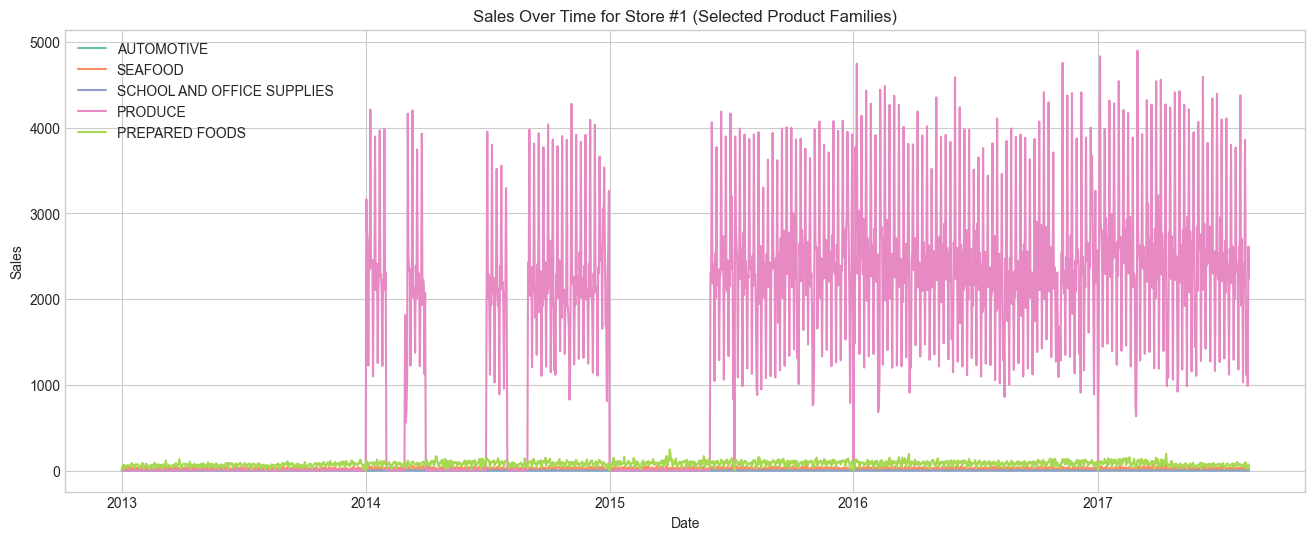

In [9]:
# Time series plot for a sample store
sample_store = train[train['store_nbr'] == 1]
sample_store['date'] = pd.to_datetime(sample_store['date'])
sample_store = sample_store.sort_values('date')

plt.figure(figsize=(16, 6))
for family in sample_store['family'].unique()[:5]:  # Plot first 5 product families
    family_data = sample_store[sample_store['family'] == family]
    plt.plot(family_data['date'], family_data['sales'], label=family)

plt.title('Sales Over Time for Store #1 (Selected Product Families)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [10]:
# Convert date to datetime
train['date'] = pd.to_datetime(train['date'])

# Create time-based features
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek
train['is_weekend'] = train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Merge with store information
train_with_store = train.merge(stores, on='store_nbr', how='left')

# Handle missing values
train_with_store['sales'] = train_with_store['sales'].fillna(0)
train_with_store['onpromotion'] = train_with_store['onpromotion'].fillna(0)

In [11]:
# Aggregate sales data by store and date
store_daily_sales = train.groupby(['store_nbr', 'date'])['sales'].sum().reset_index()

# Create a pivot table with stores as rows and dates as columns
store_time_series = store_daily_sales.pivot(index='store_nbr', columns='date', values='sales')

# Fill any missing values
store_time_series = store_time_series.fillna(0)

print("Shape of time series data:", store_time_series.shape)
store_time_series.head()

Shape of time series data: (54, 1684)


date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,0.0,7417.148000,5873.244001,5919.879001,6318.785010,2199.08700,6150.924,5597.18100,6808.57899,4757.71500,...,4409.247998,10538.136,11070.75899,12583.652,10834.579,5403.742021,7543.623,3902.782000,10433.314000,9823.551018
2,0.0,10266.718981,7612.540000,7526.377000,9539.566000,10322.38800,6675.971,6109.56701,6740.51602,5565.03601,...,16987.569000,12382.453,11304.55500,12615.753,11317.833,13081.771001,12382.416,13766.822095,12211.461020,11196.260002
3,0.0,24060.348000,18570.745025,17392.097995,22700.872005,25343.62000,17036.253,14220.41700,14735.14800,12222.91200,...,42005.370000,32074.153,28450.84300,32962.387,26035.933,32885.759996,31903.476,34845.119300,32843.704026,30185.602000
4,0.0,10200.083980,7400.245000,6902.050001,9948.383000,11679.69200,6748.196,6017.61400,5867.88300,4674.24600,...,16801.046000,10214.139,9760.26500,10671.727,8623.362,10819.543000,10622.300,13065.903000,10911.890000,9709.086000
5,0.0,10598.619020,7770.968000,7347.641991,8192.598000,10843.23203,6468.321,6427.85900,6057.10800,5950.81402,...,11264.564000,10011.661,7868.12499,9326.658,8910.066,9510.871000,8157.070,10044.821000,9011.574900,8703.693000


In [12]:
# Extract features from time series data
def extract_ts_features(series):
    """Extract features from a time series"""
    return {
        'mean': series.mean(),
        'std': series.std(),
        'median': series.median(),
        'min': series.min(),
        'max': series.max(),
        'q25': series.quantile(0.25),
        'q75': series.quantile(0.75),
        'trend': np.polyfit(np.arange(len(series)), series, 1)[0],
        'skew': series.skew(),
        'kurtosis': series.kurtosis()
    }

# Apply to each store's time series
ts_features = pd.DataFrame([extract_ts_features(store_time_series.loc[store]) 
                           for store in store_time_series.index], 
                           index=store_time_series.index)

# Scale features
scaler = StandardScaler()
ts_features_scaled = pd.DataFrame(
    scaler.fit_transform(ts_features),
    columns=ts_features.columns,
    index=ts_features.index
)

ts_features_scaled.head()

,mean,std,median,min,max,q25,q75,trend,skew,kurtosis
store_nbr,,,,,,,,,,
1,-0.435578,-0.557273,-0.346170,0.0,-0.722444,-0.390033,-0.392052,-0.521915,-0.645722,-0.363355
2,0.127172,0.150710,0.180642,0.0,3.450006,0.203150,0.054393,-0.065757,3.256362,4.089490
3,2.323134,1.913628,2.347107,0.0,1.014219,2.146846,2.345218,2.060053,-0.483599,-0.353831
4,-0.073841,-0.315870,-0.027518,0.0,-0.548943,0.006236,-0.143758,-0.339539,-0.343736,-0.335948
5,-0.325692,-0.842954,-0.258711,0.0,-0.694550,-0.060275,-0.435576,-0.993115,-0.299363,-0.278804


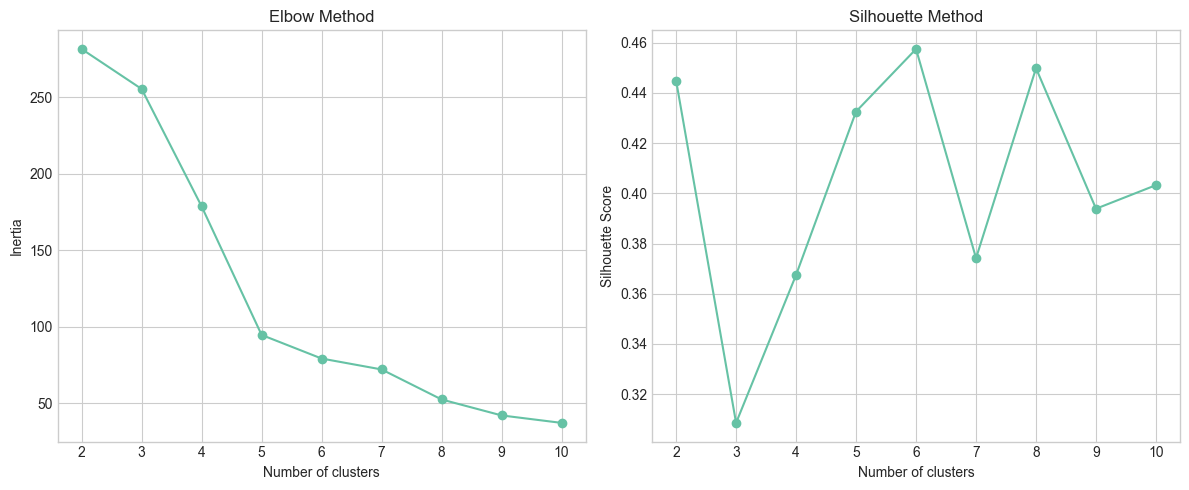

In [13]:
# Method 1: K-means clustering on extracted features
# Determine optimal number of clusters using the elbow method
inertia = []
silhouette = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ts_features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(ts_features_scaled, kmeans.labels_))

# Plot elbow method results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.tight_layout()
plt.show()

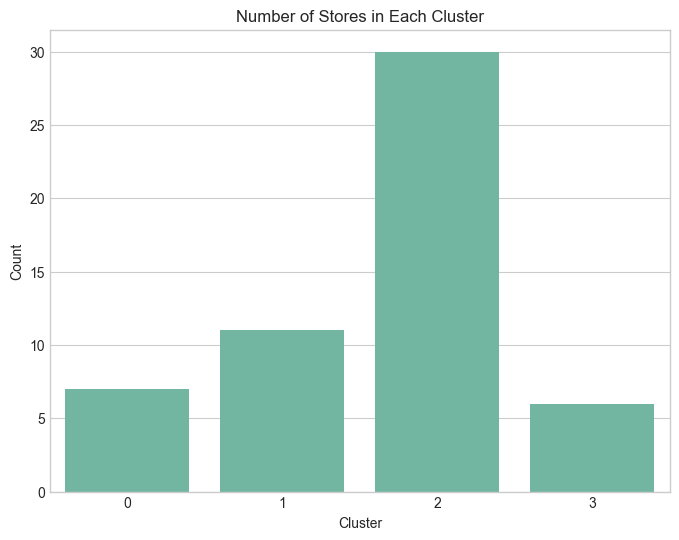

In [14]:
# Apply K-means with the optimal number of clusters (determined from the plot)
optimal_k = 4  # Adjust based on the elbow method results
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
ts_features_scaled['cluster'] = kmeans.fit_predict(ts_features_scaled)

# View cluster distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=ts_features_scaled)
plt.title('Number of Stores in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [15]:
# Method 2: Direct time series clustering with tslearn
# Reshape data for tslearn
X_train = np.array(store_time_series.values)

# Scale time series data
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train)

# Apply TimeSeriesKMeans
ts_kmeans = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", random_state=42)
ts_clusters = ts_kmeans.fit_predict(X_train_scaled)

# Add cluster labels to the dataframe
store_time_series['ts_cluster'] = ts_clusters
store_time_series[['ts_cluster']].head()

date,ts_cluster
store_nbr,
1,2
2,0
3,2
4,1
5,2


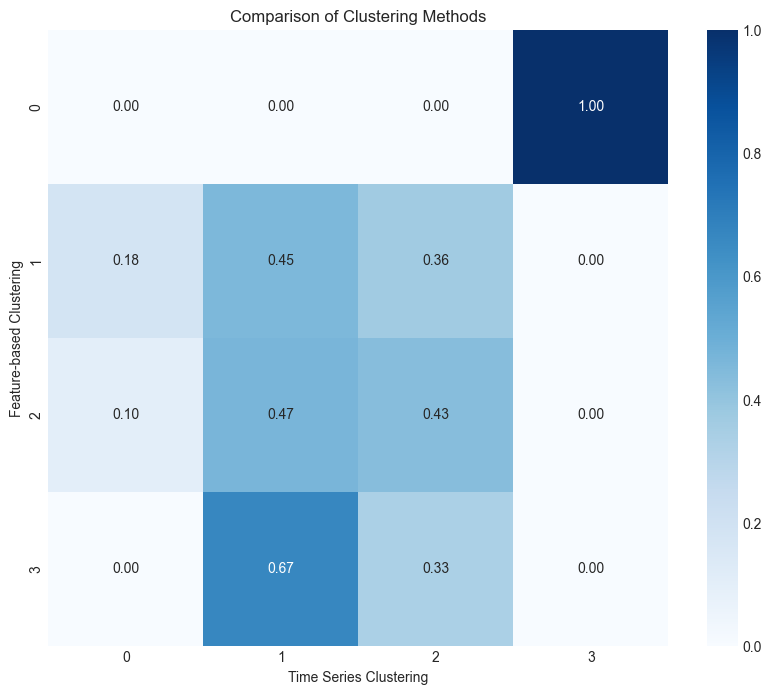

In [16]:
# Compare feature-based and direct time series clustering
cluster_comparison = pd.DataFrame({
    'store_nbr': store_time_series.index,
    'feature_cluster': ts_features_scaled['cluster'],
    'ts_cluster': store_time_series['ts_cluster']
})

# Calculate agreement between clustering methods
cross_tab = pd.crosstab(
    cluster_comparison['feature_cluster'], 
    cluster_comparison['ts_cluster'],
    normalize='index'
)

plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.2f')
plt.title('Comparison of Clustering Methods')
plt.xlabel('Time Series Clustering')
plt.ylabel('Feature-based Clustering')
plt.show()

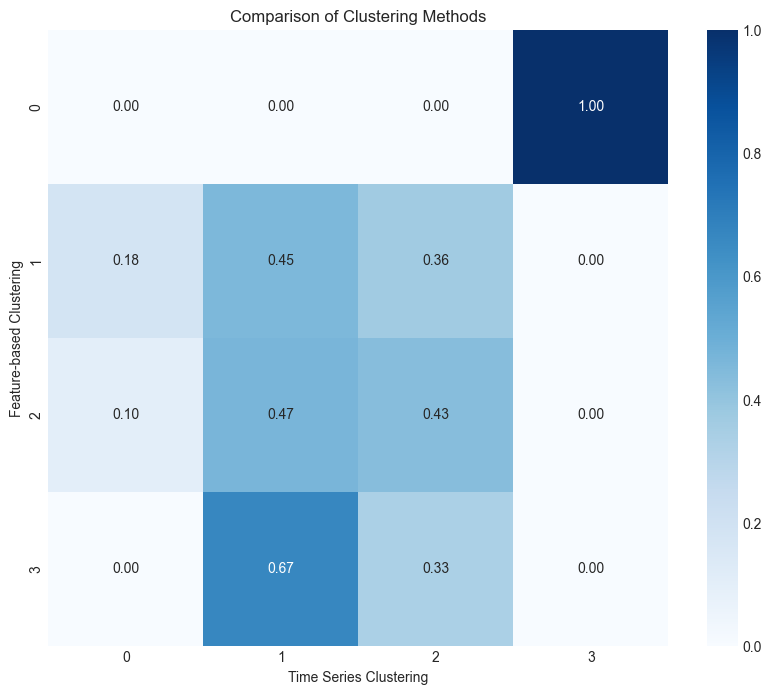

In [20]:
# Compare feature-based and direct time series clustering
# Create DataFrame from the cluster results
cluster_comparison = pd.DataFrame({
    'feature_cluster': ts_features_scaled['cluster'],
    'ts_cluster': store_time_series['ts_cluster']
}, index=store_time_series.index)

# Reset the index to make store_nbr a column
cluster_comparison = cluster_comparison.reset_index()

# Calculate agreement between clustering methods
cross_tab = pd.crosstab(
    cluster_comparison['feature_cluster'], 
    cluster_comparison['ts_cluster'],
    normalize='index'
)

plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.2f')
plt.title('Comparison of Clustering Methods')
plt.xlabel('Time Series Clustering')
plt.ylabel('Feature-based Clustering')
plt.show()

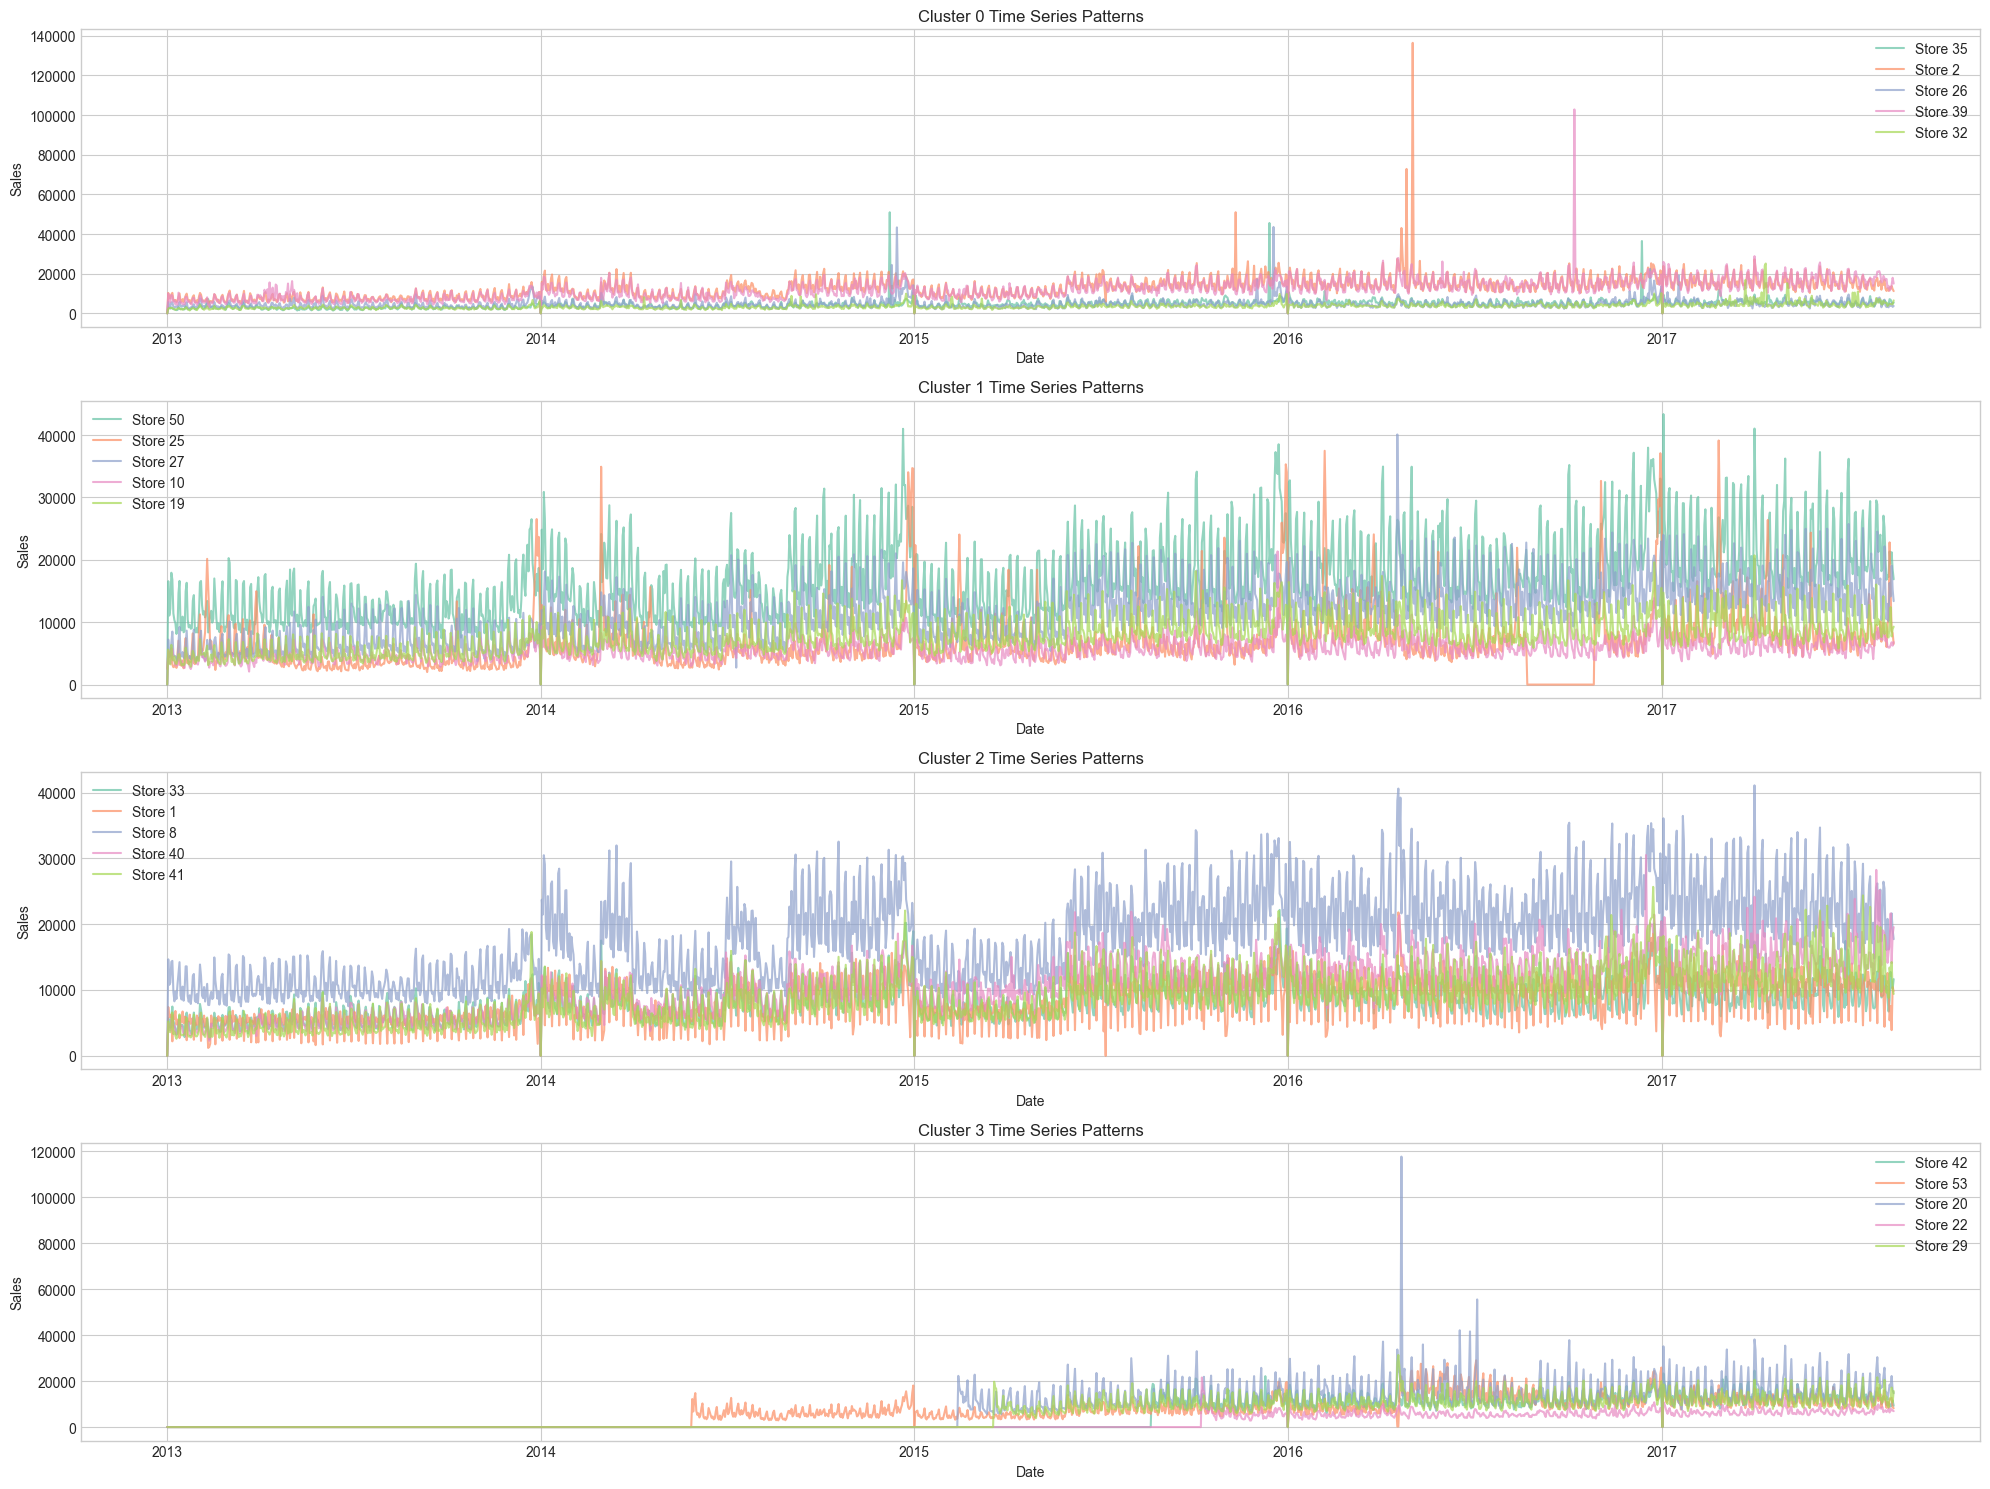

In [21]:
# Visualize the time series patterns in each cluster
plt.figure(figsize=(20, 15))

for i in range(optimal_k):
    plt.subplot(optimal_k, 1, i+1)
    
    # Get stores in this cluster
    cluster_stores = store_time_series[store_time_series['ts_cluster'] == i].index
    
    # Sample up to 5 stores to avoid overcrowding the plot
    sample_stores = np.random.choice(cluster_stores, min(5, len(cluster_stores)), replace=False)
    
    # Plot each sampled store
    for store in sample_stores:
        plt.plot(store_time_series.columns[:-1], 
                 store_time_series.loc[store, store_time_series.columns[:-1]], 
                 alpha=0.7, 
                 label=f'Store {store}')
    
    plt.title(f'Cluster {i} Time Series Patterns')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Create cluster_store_info by merging cluster results with store information
cluster_store_info = pd.merge(
    cluster_comparison,
    stores,
    on='store_nbr'
)

# Calculate average metrics for each cluster
cluster_stats = cluster_store_info.groupby('feature_cluster').agg({
    'type': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'store_nbr': 'count'
}).rename(columns={'store_nbr': 'store_count'})

# Merge with original features to see characteristics
cluster_features = ts_features.copy()
cluster_features['cluster'] = ts_features_scaled['cluster']
cluster_profiles = cluster_features.groupby('cluster').mean()

# Combine stats and profiles
cluster_analysis = pd.concat([cluster_stats, cluster_profiles], axis=1)
cluster_analysis

,type,store_count,mean,std,median,min,max,q25,q75,trend,skew,kurtosis
0,B,7,4992.358741,6156.441488,2936.884786,0.0,41877.864423,0.000000,8700.582559,9.507257,1.299643,3.544134
1,D,11,16218.957589,6250.958635,15704.067173,0.0,59563.044175,11471.254993,19932.795701,7.246565,1.456729,18.617269
2,C,30,8135.849469,3143.171565,7881.517350,0.0,27115.366797,5879.163908,9893.599151,3.545395,1.314247,11.765469
3,A,6,30020.976031,12538.399920,28835.959748,0.0,81156.680937,19969.481408,37312.781945,15.616901,0.614224,0.117673


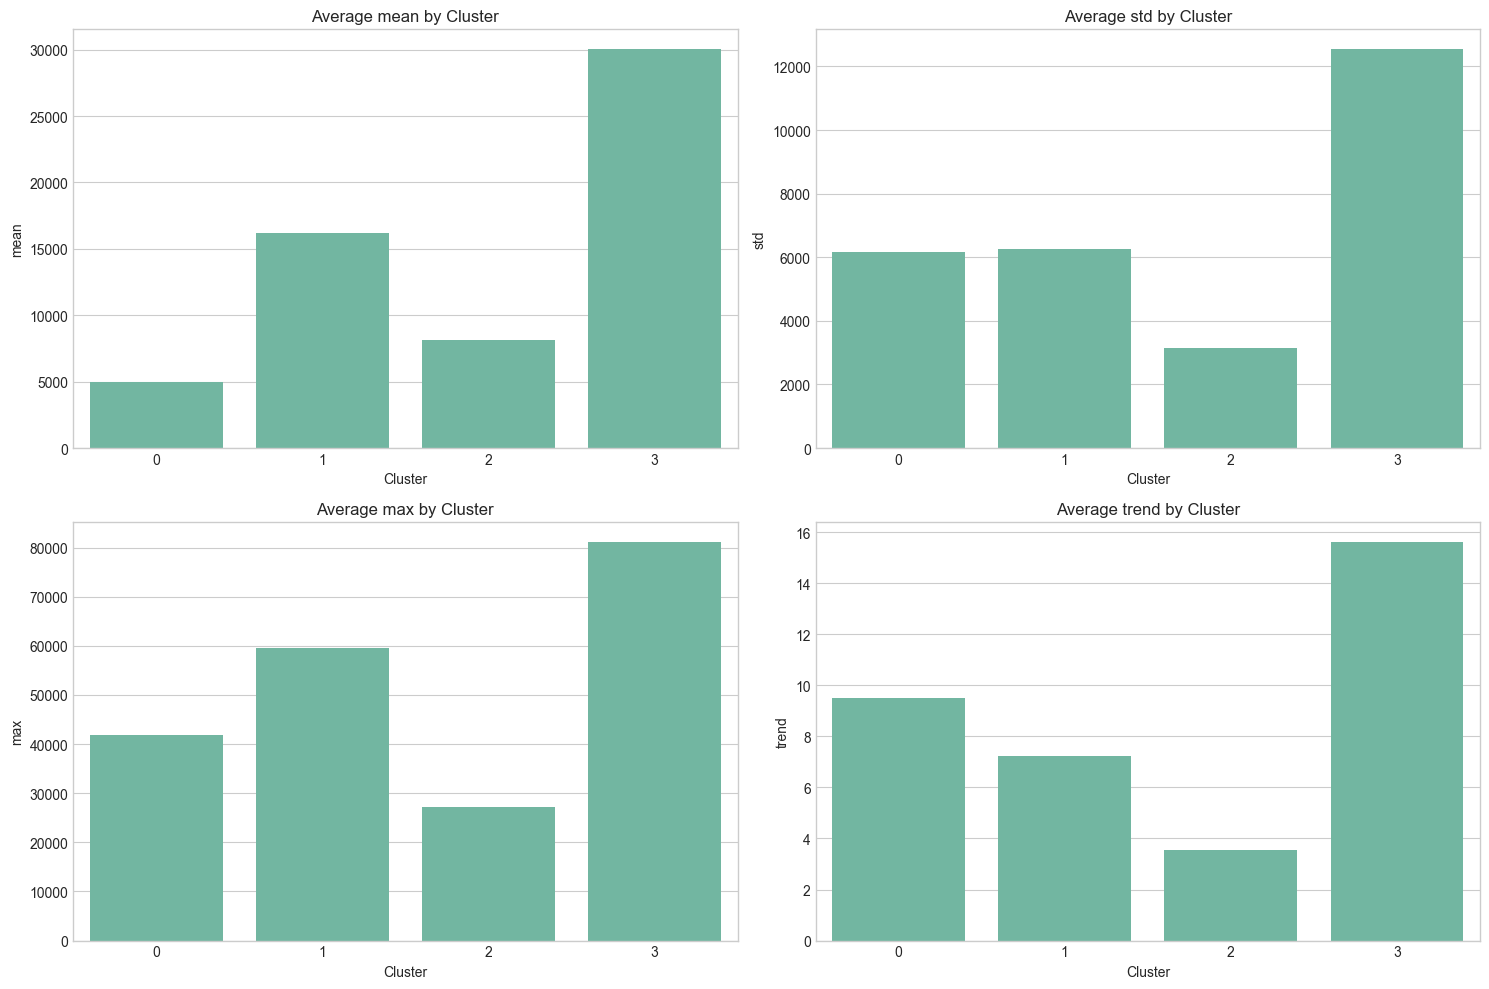

In [26]:
# Visualize key metrics by cluster
metrics = ['mean', 'std', 'max', 'trend']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=cluster_analysis.index, y=cluster_analysis[metric])
    plt.title(f'Average {metric} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

In [27]:
# Summarize findings
print("Summary of Store Clusters:")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    print(f"Number of stores: {cluster_analysis.loc[cluster, 'store_count']}")
    print(f"Predominant store type: {cluster_analysis.loc[cluster, 'type']}")
    print(f"Average sales: {cluster_analysis.loc[cluster, 'mean']:.2f}")
    print(f"Sales volatility: {cluster_analysis.loc[cluster, 'std']:.2f}")
    print(f"Sales trend: {'Increasing' if cluster_analysis.loc[cluster, 'trend'] > 0 else 'Decreasing'}")

Summary of Store Clusters:

Cluster 0:
Number of stores: 7
Predominant store type: B
Average sales: 4992.36
Sales volatility: 6156.44
Sales trend: Increasing

Cluster 1:
Number of stores: 11
Predominant store type: D
Average sales: 16218.96
Sales volatility: 6250.96
Sales trend: Increasing

Cluster 2:
Number of stores: 30
Predominant store type: C
Average sales: 8135.85
Sales volatility: 3143.17
Sales trend: Increasing

Cluster 3:
Number of stores: 6
Predominant store type: A
Average sales: 30020.98
Sales volatility: 12538.40
Sales trend: Increasing
